In [16]:
import collections
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import pandas as pd
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
from tensorflow.keras.layers import Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
from tensorflow import keras
from tensorflow import convert_to_tensor, string
import tensorflow.keras.layers as layers
from keras.utils.vis_utils import plot_model

## Process the midi files

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 44100

In [8]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [5]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [7]:
sample_file = "data/maestro-v2.0.0/2017/MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--2.midi"   # You can also put filenames[index]
pm = pretty_midi.PrettyMIDI(sample_file)
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)
display_audio(pm)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [9]:
# preprocessing, we want notes represented as (pitch, time, duration)
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name : np.array(value) for name, value in notes.items()})

In [10]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     48  0.991667  1.067708  0.000000  0.076042
1     36  1.000000  3.026042  0.008333  2.026042
2     48  1.162500  1.248958  0.162500  0.086458
3     55  1.268750  1.353125  0.106250  0.084375
4     60  1.343750  1.428125  0.075000  0.084375

In [11]:
num_files = 10
all_notes = []
n_notes = 0
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)
  n_notes += len(notes)
print("processed", n_notes, "notes")

key_order = ['pitch', 'start', 'duration', 'step']
train_notes = []
for piece in all_notes:
  train_notes.append(np.stack([piece[key] for key in key_order], axis=1))

notes_ds = [tf.data.Dataset.from_tensor_slices(piece) for piece in train_notes]
print(notes_ds[0].element_spec)

processed 68137 notes
TensorSpec(shape=(4,), dtype=tf.float64, name=None)


## Convert notes to dataset

In [12]:
output_columns = ['pitch', 'step', 'duration']
output_order = {label:key_order.index(label) for label in output_columns}
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1, :-1]    # remove the 'step' column from the input
    labels_dense = sequences[1:]
    labels = {key:labels_dense[:,i] for key,i in output_order.items()}

    return inputs, labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
seq_length = 64
x_seqs = []
for ds in notes_ds:
    x = create_sequences(ds, seq_length)
    x_seqs.append(x)

x = tf.data.Dataset.sample_from_datasets(x_seqs)
print(x.element_spec)

(TensorSpec(shape=(64, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})


In [24]:
batch_size = 32
buffer_size = n_notes - seq_length
train_ds = (x
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(32, 64, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(32, 64), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(32, 64), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(32, 64), dtype=tf.float64, name=None)})

In [25]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [30]:
class ContinuousPositionalEmbedding(Layer):
    def __init__(self, output_dim, base=10_000, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.n = base

    def tile(self, v, batch_size, seq_len):
        return tf.repeat(tf.repeat(v[tf.newaxis, :], seq_len, axis=0)[tf.newaxis, :], batch_size, axis=0)

    @tf.function
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        base = tf.fill((self.output_dim,), tf.cast(self.n, dtype=tf.float32))
        v_embed = tf.math.pow(base, tf.math.floor(0.5 * tf.range(self.output_dim, dtype=tf.float32))/self.output_dim)
        m_embed = self.tile(v_embed, batch_size, seq_len)        # should have shape (batch_size, seq_len, embed_dim)
        m_embed = tf.repeat(inputs, self.output_dim, axis=-1) / m_embed
        m_embed = tf.concat([tf.math.sin(m_embed[:, :, 0::2]), tf.math.cos(m_embed[:, :, 1::2])], axis=-1)  # note, sin and cos are no longer adjacent, interleaving is too difficult

        return m_embed

In [27]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [28]:
embed_dim = 512
vocab_size = 128
feed_forward_dim = 256
learning_rate = 0.005

def create_model():
    inputs = layers.Input(shape=(None, 3))
    pitch_embedding = layers.Embedding(vocab_size, embed_dim, trainable=True)(inputs[:,:,0])
    time_embedding = ContinuousPositionalEmbedding(embed_dim)(inputs[:,:,1:2])
    duration_embedding = ContinuousPositionalEmbedding(embed_dim)(inputs[:,:,2:])
    embedding = layers.Add()([pitch_embedding, time_embedding, duration_embedding])
    #concat = layers.Concatenate()([embedding, inputs[:,:,2:]])
    x = TransformerBlock(embed_dim, 4, feed_forward_dim)(embedding)
    x = TransformerBlock(embed_dim, 4, feed_forward_dim)(x + embedding)
    x = TransformerBlock(embed_dim, 4, feed_forward_dim)(x + embedding)
    #x = TransformerBlock(embed_dim, 4, feed_forward_dim)(x + embedding)
    a = layers.Dense(64, activation="relu")(x)
    pitch_output = layers.Dense(vocab_size, name="pitch")(a)
    step_output = layers.Dense(1, activation='softplus', name="step")(a)
    duration_output = layers.Dense(1, activation='softplus', name="duration")(a)
    outputs = {
        'pitch':pitch_output,
        'step':step_output,
        'duration':duration_output
    }

    model = keras.Model(inputs=inputs, outputs=outputs)

    loss = {
        'pitch' : keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,     # mse works too, use mse_with_positive_pressure if last activation is linear
        'duration': mse_with_positive_pressure
    }

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss=loss,
        loss_weights = {
            'pitch':1.0,
            'duration':1.0,
            'step':1.0
        },
        optimizer=optimizer
    )
    model.summary()

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, None)        0           ['input_4[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_7 (Sl  (None, None, 1)     0           ['input_4[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

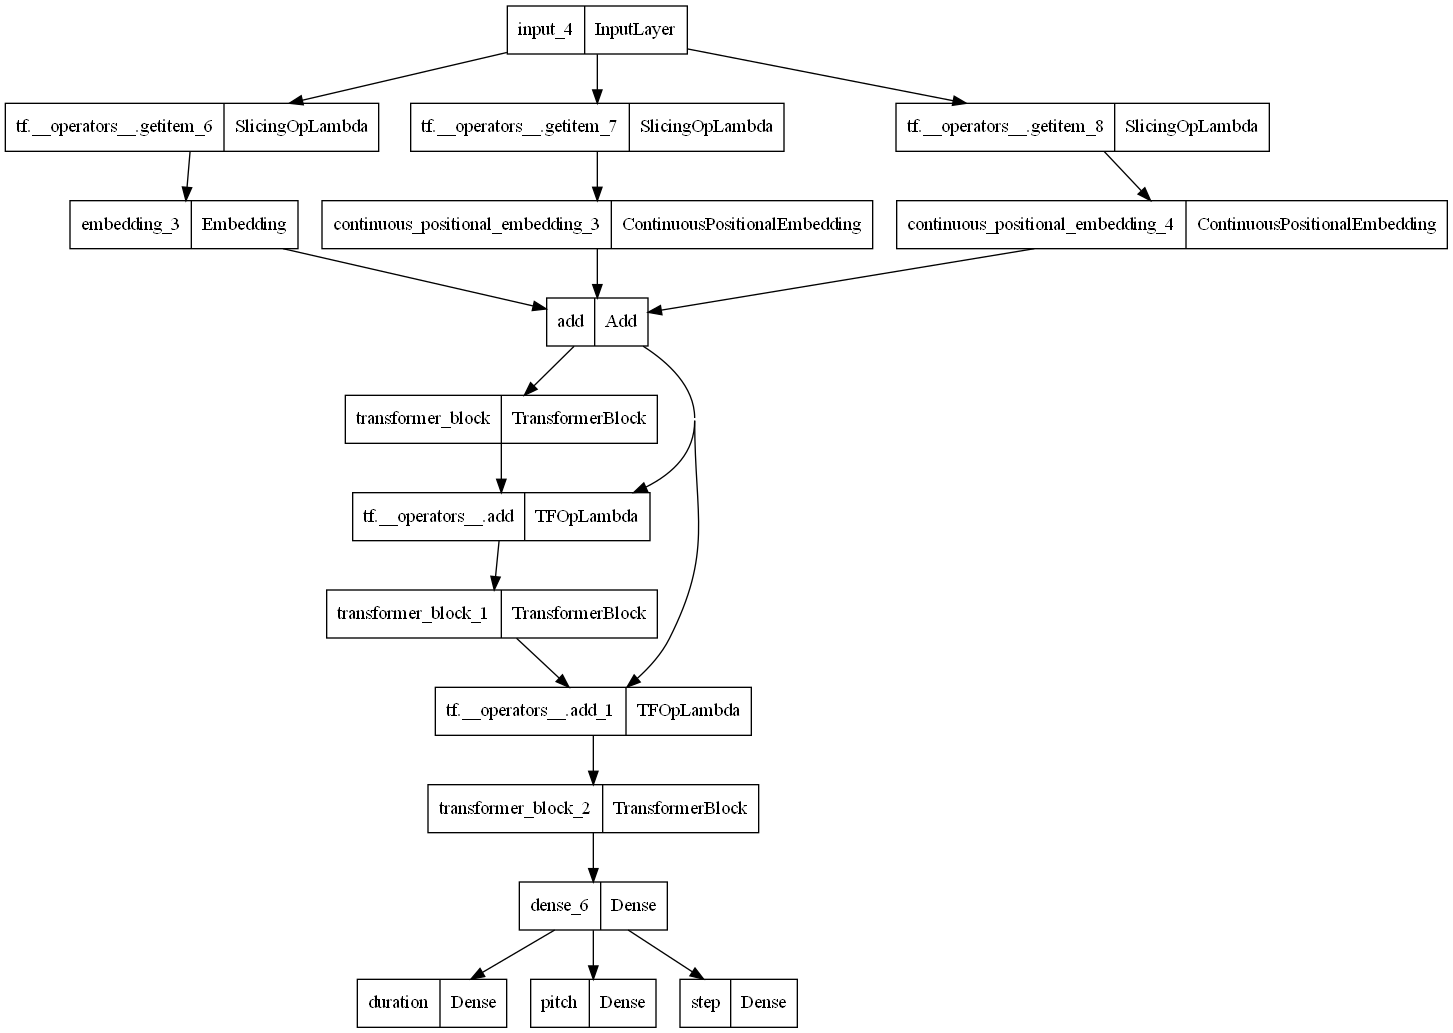

In [32]:
model = create_model()
plot_model(model)

In [31]:
# IF loading weights
#model.load_weights('./tmp/checkpoint')

In [33]:
model.evaluate(train_ds, return_dict=True)      # Skip if you want

KeyboardInterrupt: 

In [ ]:
%%time
epochs = 20     # takes hella long even with gpu

checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='pitch_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_ds, epochs=epochs, callbacks=[model_checkpoint_callback])

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate music

In [34]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)   # (1, n, 3)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch'][:1,-1]   # (1, 128)
  step = predictions['step'][:1,-1]            # (1, 1)
  duration = predictions['duration'][:1,-1]    # (1, 1)
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [40]:
temperature = 1   # higher = more randomness
num_predictions = 100

sample_notes = np.stack([raw_notes[key] for key in key_order[:-1]], axis=1)
input_notes = sample_notes[:seq_length]  # (seq_length, 3) => pitch, start, duration

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, input_notes[-1][1] + step, duration)
    generated_notes.append((pitch, step, duration, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=('pitch', 'step', 'duration', 'start', 'end')
)

1/1 [==============================] - 0s 16ms/step


In [41]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [42]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [43]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

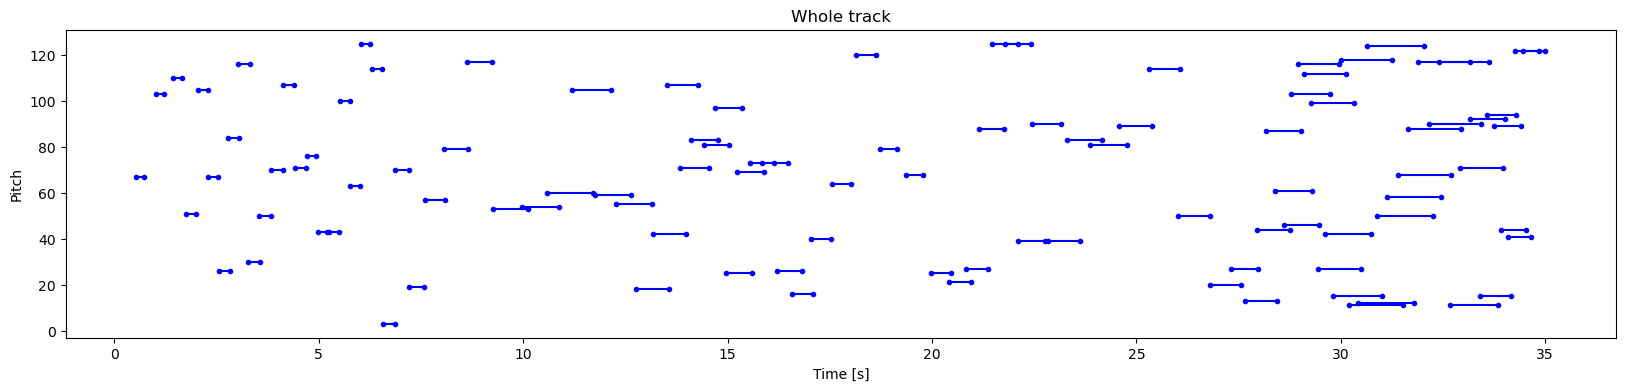

In [44]:
plot_piano_roll(generated_notes)